In [28]:
import numpy as np
import yaml
from matplotlib import pyplot as plt
from matplotlib import cm

from utils import load_runs, is_crystal

In [29]:
ds_name = 'water' # water OR gdlyz

onecolor_ds_name = ds_name + '_onecolor'

runs = yaml.safe_load(open('runs.yaml', 'r'))
runs_to_analyze = runs[ds_name]

onecolor_runs   = runs[onecolor_ds_name]

print(runs_to_analyze)
print(onecolor_runs)

auc_to_mJ = 1.60324933931e-07

[127, 144, 148, 150, 152, 154, 166, 168, 171, 174, 179, 184, 189, 192, 194, 205, 207, 209, 212, 215, 232, 234, 236, 248, 257, 261, 263]
[131, 133]


In [30]:
d    = load_runs(runs_to_analyze[:], file_loc="/Users/tjlane/Desktop/scratch-smalldata/")
oc_d = load_runs(onecolor_runs[:], one_color=True, file_loc="/Users/tjlane/Desktop/scratch-smalldata/")

run 127 not on disk...
WARNING! Issue loading run: 148
"Unable to open object (object 'probe_energy' doesn't exist)"
Attempting to continue...
WARNING! Issue loading run: 154
"Unable to open object (object 'probe_energy' doesn't exist)"
Attempting to continue...
WARNING! Issue loading run: 168
"Unable to open object (object 'probe_energy' doesn't exist)"
Attempting to continue...
WARNING! Issue loading run: 171
"Unable to open object (object 'probe_energy' doesn't exist)"
Attempting to continue...
WARNING! Issue loading run: 194
"Unable to open object (object 'probe_energy' doesn't exist)"
Attempting to continue...
WARNING! Issue loading run: 232
"Unable to open object (object 'probe_energy' doesn't exist)"
Attempting to continue...
WARNING! Issue loading run: 248
"Unable to open object (object 'probe_energy' doesn't exist)"
Attempting to continue...


--- LOADED 27 RUNS --
probe_energy              : (91052,)
probe_mag                 : (91052,)
pp_delay                  : (91052,)
pu

### summarize data

water :: 27 runs :: 91052 shots



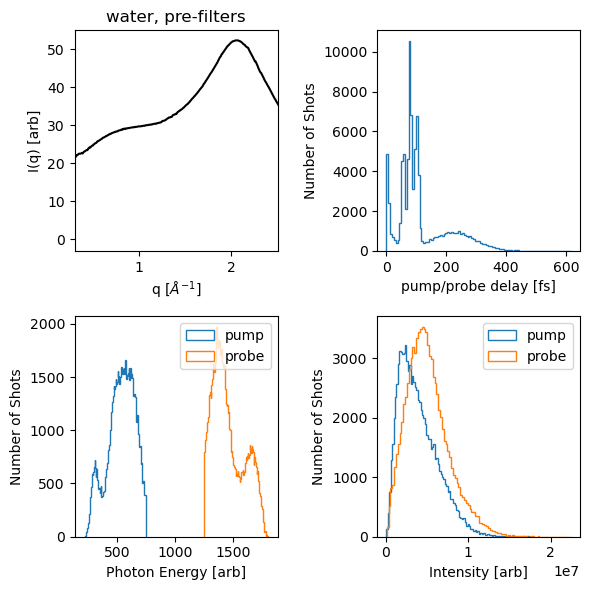

In [31]:
plt.figure(figsize=(6,6))

print('%s :: %d runs :: %d shots\n' % (ds_name, len(runs_to_analyze), len(d['pp_delay']) ))

plt.subplot(221)
plt.title('%s, pre-filters' % ds_name)
plt.plot(d['radial_profile_qvalues'], d['radial_profile'].mean(axis=0), color='k')
plt.xlabel('q [$\AA^{-1}$]')
plt.ylabel('I(q) [arb]')
plt.xlim([0.3, 2.5])

plt.subplot(222)
plt.hist(d['pp_delay'], histtype='step', bins=100)
plt.xlabel('pump/probe delay [fs]')
plt.ylabel('Number of Shots')

plt.subplot(223)
plt.hist(d['pump_energy'], histtype='step', bins=100)
plt.hist(d['probe_energy'], histtype='step', bins=100)
plt.xlabel('Photon Energy [arb]')
plt.ylabel('Number of Shots')
plt.legend(['pump', 'probe'])

plt.subplot(224)
plt.hist(d['pump_mag'], histtype='step', bins=100)
plt.hist(d['probe_mag'], histtype='step', bins=100)
plt.xlabel('Intensity [arb]')
plt.ylabel('Number of Shots')
plt.legend(['pump', 'probe'])

plt.tight_layout()
#plt.savefig('figures/summary/%s_prefilter.pdf' % ds_name)
plt.show()

## Vetoes / Filtering

In [32]:
keep = \
    (d['pump_mag']     > 1.e6)  * (d['pump_mag']     < 1.e7) *\
    (d['probe_mag']    > 1.e6)  * (d['probe_mag']    < 1.e7) *\
    (d['pump_energy']  > 369.)  * (d['pump_energy']  < 750.) *\
    (d['pp_delay']     > 0.00)  * (d['pp_delay']     < 125.) *\
     np.logical_not(is_crystal(d['radial_profile']))


if ds_name == 'water':
    keep = keep * (d['probe_energy'] > 1250.) * (d['probe_energy'] < 1510)
elif ds_name == 'gdlyz':
    keep = keep * (d['probe_energy'] > 1500.) * (d['probe_energy'] < 1750)
    
    
print("retaining %d/%d shots" % (np.sum(keep), d['pp_delay'].shape[0]))

retaining 27840/91052 shots


In [33]:
oc_keep = np.logical_not(is_crystal(oc_d['radial_profile']))

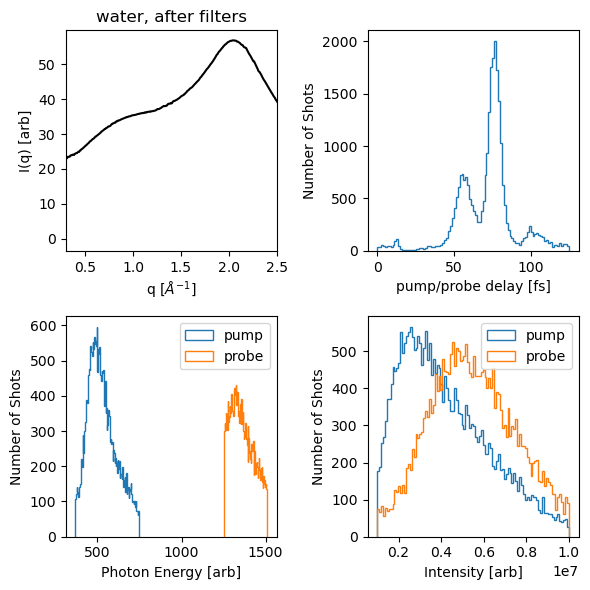

In [34]:
rad_prf = d['radial_profile'][keep]
pmp_mag = d['pump_mag'][keep]
pmp_nrg = d['pump_energy'][keep]
prb_mag = d['probe_mag'][keep]
prb_nrg = d['probe_energy'][keep]
pp_dlay = d['pp_delay'][keep]

rad_prf_oc = oc_d['radial_profile'][oc_keep]

plt.figure(figsize=(6,6))

plt.subplot(221)
plt.title('%s, after filters' % ds_name)
plt.plot(d['radial_profile_qvalues'], rad_prf.mean(axis=0), color='k')
plt.xlabel('q [$\AA^{-1}$]')
plt.ylabel('I(q) [arb]')
plt.xlim([0.3, 2.5])

plt.subplot(222)
plt.hist(pp_dlay, histtype='step', bins=100)
plt.xlabel('pump/probe delay [fs]')
plt.ylabel('Number of Shots')

plt.subplot(223)
plt.hist(pmp_nrg, histtype='step', bins=100)
plt.hist(prb_nrg, histtype='step', bins=100)
plt.xlabel('Photon Energy [arb]')
plt.ylabel('Number of Shots')
plt.legend(['pump', 'probe'])

plt.subplot(224)
plt.hist(pmp_mag, histtype='step', bins=100)
plt.hist(prb_mag, histtype='step', bins=100)
plt.xlabel('Intensity [arb]')
plt.ylabel('Number of Shots')
plt.legend(['pump', 'probe'])

plt.tight_layout()
#plt.savefig('figures/summary/%s_postfilter.pdf' % ds_name)
plt.show()

## Key Plots :)
RP vs Delay Time / RP vs Pump Power

In [35]:
def normalize(radial_profile, rng=(50, 340)):
    div = radial_profile[...,rng[0]:rng[1]].sum(-1)[...,None]
    return radial_profile / ( div + 1e-16)

qrng_str = 'q normalized between %.2f -> %.2f' % (d['radial_profile_qvalues'][50], d['radial_profile_qvalues'][340])
print(qrng_str)

q normalized between 0.37 -> 2.52


In [46]:
# make a 3d cube of rp vs time vs pump-power

# --- peak positions to monitor later (in array idx)
new_peak_pos = 90
wat_peak_pos = 280

# --- bin values
if ds_name == 'water':
    time_delays = np.array([10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0])
elif ds_name == 'gdlyz':
    time_delays = np.array([25.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0])

pump_powers = np.linspace(1e6, 1e7, 10)


# --- assignments & volumes to hold results
pp_assignment = np.digitize(pp_dlay, time_delays)
pw_assignment = np.digitize(pmp_mag, pump_powers)

w_rad_prf = rad_prf / prb_mag[:,None]
#w_rad_prf = normalize(w_rad_prf) # seems better without

rp_means        = np.zeros((len(time_delays), len(pump_powers), w_rad_prf.shape[1]))
rp_95ci         = np.zeros((len(time_delays), len(pump_powers), w_rad_prf.shape[1]))
n_shots_per_bin = np.zeros((len(time_delays), len(pump_powers)), dtype=int)



# --- loop & bin data accordingly

for delay_idx, delay in enumerate(time_delays):
    for power_idx, power in enumerate(pump_powers):

        idx = (pp_assignment == delay_idx) * (pw_assignment == power_idx)
        
        n = np.sum(idx)
        if n > 0:
            rp_means[delay_idx, power_idx] = w_rad_prf[idx].mean(axis=0)
            rp_95ci[delay_idx, power_idx] = 1.95 * w_rad_prf[idx].std(axis=0) / np.sqrt(n)
        n_shots_per_bin[delay_idx, power_idx] = n

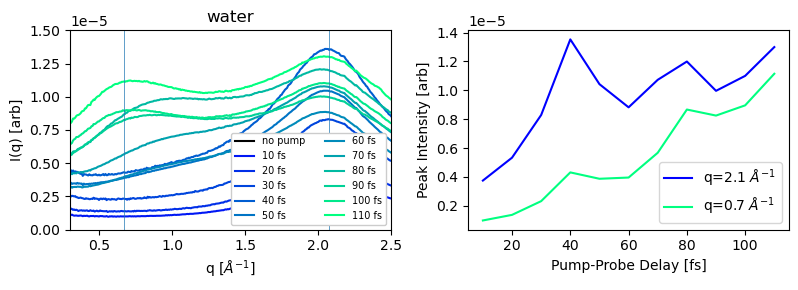

In [37]:
# RP vs Delay Time
# NOT normalized with AUC method
# ....

# --- plotting
plt.figure(figsize=(8,3))

plt.subplot(121)
plt.title(ds_name)

plt.plot(oc_d['radial_profile_qvalues'],
         rad_prf_oc.mean(0),
         color='k')

n_shots_oc = rad_prf_oc.shape[0]

wat_peak_intensities = []
new_peak_intensities = []
csv_data = [d['radial_profile_qvalues'], ] # to write out a csv

for i,b in enumerate(time_delays):
    
    # avg powers // intensity normalized
    rp = rp_means[i,:,:].mean(0)
    
    plt.plot(d['radial_profile_qvalues'], rp,
             color=cm.winter(b/time_delays.max()))
    
    csv_data.append(rp)
    
    wat_peak_intensities.append(rp[wat_peak_pos])
    new_peak_intensities.append(rp[new_peak_pos])

plt.xlabel('q [$\AA^{-1}]$')
plt.ylabel('I(q) [arb]')
plt.xlim([0.3, 2.5])
plt.ylim([0.0, 0.000015])
plt.vlines([d['radial_profile_qvalues'][new_peak_pos],
            d['radial_profile_qvalues'][wat_peak_pos]], 
           0.0, 0.007, lw=0.5)
plt.legend(['no pump'] + ['%d fs' % b for b in time_delays], 
           prop={'size': 7}, ncol=2, framealpha=1.0)


rp_means = np.array(rp_means)
plt.subplot(122)
plt.plot(time_delays, wat_peak_intensities, color=cm.winter(0.0))
plt.plot(time_delays, new_peak_intensities, color=cm.winter(1.0))
plt.xlabel('Pump-Probe Delay [fs]')
plt.ylabel('Peak Intensity [arb]')
plt.legend(['q=%.1f $\AA^{-1}$' % d['radial_profile_qvalues'][wat_peak_pos],
            'q=%.1f $\AA^{-1}$' % d['radial_profile_qvalues'][new_peak_pos]])

plt.tight_layout()
#plt.savefig('figures/profile_v_time/%s_pvt.pdf' % ds_name)
plt.show()


# write a CSV for export to collaborators
csv_data = np.array(csv_data).T # column-major
header = '# q/A,' + 'fs,'.join([ str(x) for x in time_delays ]) + '\n'
#np.savetxt('csvs/%s_Iq_v_time.csv' % ds_name, csv_data, header=header, delimiter=',', fmt='%.8f')

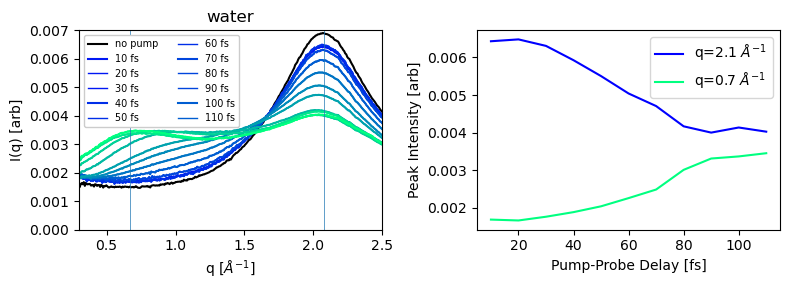

In [45]:
# RP vs Delay Time

# --- plotting
plt.figure(figsize=(8,3))

plt.subplot(121)
plt.title(ds_name)

plt.plot(oc_d['radial_profile_qvalues'],
         normalize(rad_prf_oc.mean(0)),
         color='k')

n_shots_oc = rad_prf_oc.shape[0]

wat_peak_intensities = []
new_peak_intensities = []
csv_data = [d['radial_profile_qvalues'], ] # to write out a csv

for i,b in enumerate(time_delays):
    
    rp = normalize(rp_means[i,:,:].mean(0)) # avg powers
    
    plt.plot(d['radial_profile_qvalues'], rp,
             color=cm.winter(b/time_delays.max()))
    
    csv_data.append(rp)
    
    wat_peak_intensities.append(rp[wat_peak_pos])
    new_peak_intensities.append(rp[new_peak_pos])

plt.xlabel('q [$\AA^{-1}]$')
plt.ylabel('I(q) [arb]')
plt.xlim([0.3, 2.5])
plt.ylim([0.0, 0.007])
plt.vlines([d['radial_profile_qvalues'][new_peak_pos],
            d['radial_profile_qvalues'][wat_peak_pos]], 
           0.0, 0.007, lw=0.5)
plt.legend(['no pump'] + ['%d fs' % b for b in time_delays], 
           prop={'size': 7}, ncol=2, framealpha=1.0)


rp_means = np.array(rp_means)
plt.subplot(122)
plt.plot(time_delays, wat_peak_intensities, color=cm.winter(0.0))
plt.plot(time_delays, new_peak_intensities, color=cm.winter(1.0))
plt.xlabel('Pump-Probe Delay [fs]')
plt.ylabel('Peak Intensity [arb]')
plt.legend(['q=%.1f $\AA^{-1}$' % d['radial_profile_qvalues'][wat_peak_pos],
            'q=%.1f $\AA^{-1}$' % d['radial_profile_qvalues'][new_peak_pos]])

plt.tight_layout()
#plt.savefig('figures/profile_v_time/%s_pvt.pdf' % ds_name)
plt.show()


# write a CSV for export to collaborators
csv_data = np.array(csv_data).T # column-major
header = '# q/A,' + 'fs,'.join([ str(x) for x in time_delays ]) + '\n'
#np.savetxt('csvs/%s_Iq_v_time.csv' % ds_name, csv_data, header=header, delimiter=',', fmt='%.8f')

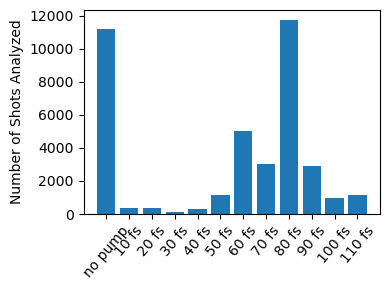

In [40]:
plt.figure(figsize=(4,3))
plt.bar(['no pump'] + ['%d fs' % b for b in time_delays], 
        np.concatenate([[n_shots_oc], n_shots_per_bin.sum(1)]))
plt.xticks(rotation=50)
plt.ylabel('Number of Shots Analyzed')
plt.tight_layout()
#plt.savefig('figures/shotcount_%s.pdf' % ds_name)
plt.show()

(11, 10, 500)
(11, 11) (11,) (500, 500)


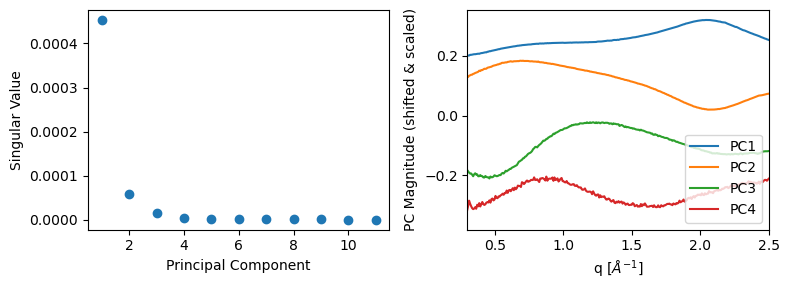

In [41]:
# SVD

print(rp_means.shape)
u, s, vh = np.linalg.svd(rp_means.mean(1))
print(u.shape, s.shape, vh.shape)

plt.figure(figsize=(8,3))

plt.subplot(121)
plt.plot(np.arange(1, s.shape[0]+1), s, 'o')
plt.xlabel('Principal Component')
plt.ylabel('Singular Value')


plt.subplot(122)
# make sure the signs are correct, offsets for visual appeal
plt.plot(d['radial_profile_qvalues'],
         vh[:4,:].T * np.array([-3,1,1,1]) + np.array([0.1,0.1,-0.1,-0.25])) 

plt.xlabel('q [$\AA^{-1}]$')
plt.ylabel('PC Magnitude (shifted & scaled)')
plt.xlim([0.3, 2.5])
#plt.ylim([0.0, 0.007])
plt.legend(['PC1', 'PC2', 'PC3', 'PC4'], loc=4)

plt.tight_layout()
#plt.savefig('figures/svd_%s.pdf' % ds_name)
plt.show()

Using 10.0 fs timebin
Using 20.0 fs timebin
Using 30.0 fs timebin
Using 40.0 fs timebin
Using 50.0 fs timebin
Using 60.0 fs timebin
Using 70.0 fs timebin
Using 80.0 fs timebin
Using 90.0 fs timebin
Using 100.0 fs timebin
Using 110.0 fs timebin


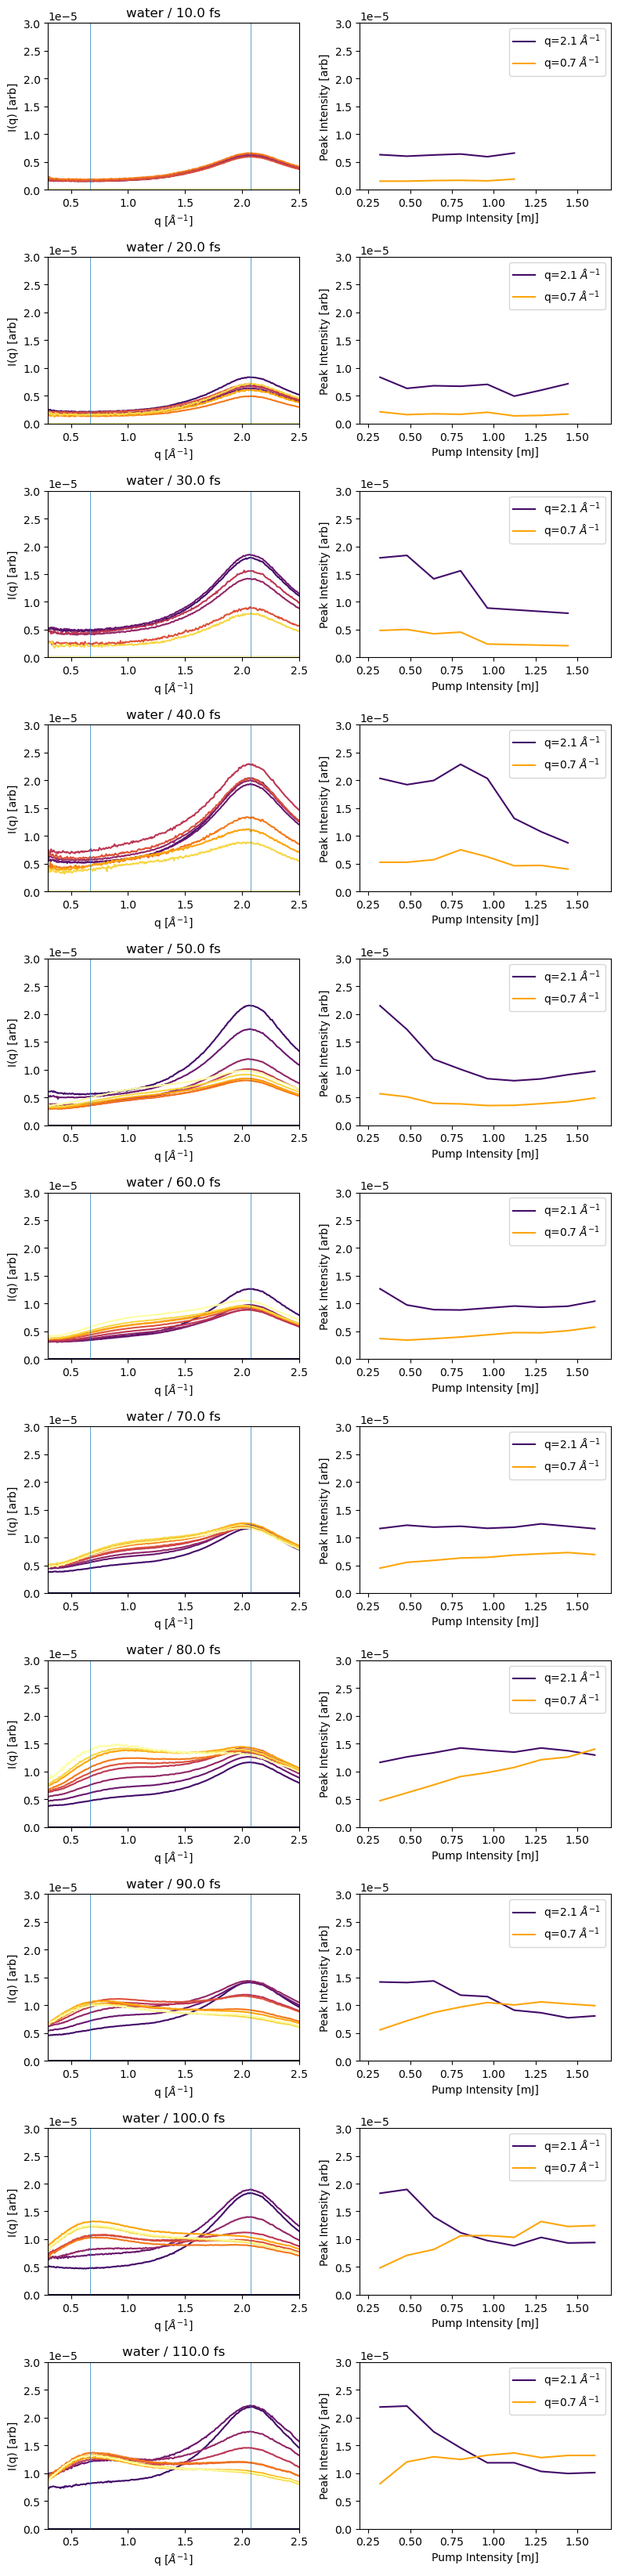

In [49]:
# new peak intensity vs pump power

do_normalize = False

n_delays = len(time_delays)

# --- figure
plt.figure(figsize=(8,3*n_delays))

for delay_idx, delay in enumerate(time_delays):
    
    wat_peak_rp = []
    new_peak_rp = []
    csv_data    = [d['radial_profile_qvalues']]

    print('Using %.1f fs timebin' % time_delays[delay_idx])
    chosen_rp = rp_means[delay_idx,:,:]

    plt.subplot(n_delays, 2, 1 + 2*delay_idx)
    plt.title('%s / %.1f fs' % (ds_name, time_delays[delay_idx]))
    for pw_idx, bp in enumerate(pump_powers):

        if do_normalize:
            prp_mean = normalize(chosen_rp[pw_idx])
        else:
            prp_mean = chosen_rp[pw_idx]

        plt.plot(d['radial_profile_qvalues'], 
                 prp_mean,
                 color=cm.inferno(bp/pump_powers.max()))
        
        # plt.plot(d['radial_profile_qvalues'], 
        #          prp_mean + rp_95ci[delay_idx,pw_idx,:],
        #          color=cm.inferno(bp/pump_powers.max()), linestyle="--")
        # plt.plot(d['radial_profile_qvalues'], 
        #          prp_mean - rp_95ci[delay_idx,pw_idx,:],
        #          color=cm.inferno(bp/pump_powers.max()), linestyle="--")
        
        wat_peak_rp.append(prp_mean[wat_peak_pos])
        new_peak_rp.append(prp_mean[new_peak_pos])
        csv_data.append(prp_mean)
        
    # write a CSV for export to collaborators
    csv_data = np.array(csv_data).T # column-major
    header = '# q/A,' + 'x,'.join([ str(x) for x in pump_powers ]) + '\n'
    # np.savetxt('csvs/%s_Iq_v_power_%dfs.csv' % (ds_name, int(time_delays[delay_idx])), 
    #            csv_data, header=header, delimiter=',', fmt='%.8f')
        
    plt.xlabel('q [$\AA^{-1}]$')
    plt.ylabel('I(q) [arb]')
    plt.xlim([0.3, 2.5])
    if do_normalize:
        plt.ylim([0.0, 0.007])
    else:
        plt.ylim([0.0, 0.00003])
    plt.vlines([d['radial_profile_qvalues'][new_peak_pos],
                d['radial_profile_qvalues'][wat_peak_pos]], 
               0.0, 0.007, lw=0.5)
    #plt.legend(['power=%.0e' % p for p in pump_powers], prop={'size': 7}, ncol=2)

    plt.subplot(n_delays, 2, 2 + 2*delay_idx)
    wat_peak_rp = np.array(wat_peak_rp)
    new_peak_rp = np.array(new_peak_rp)
    plt.plot(pump_powers[wat_peak_rp>0] * auc_to_mJ, wat_peak_rp[wat_peak_rp>0], color=cm.inferno(0.2))
    plt.plot(pump_powers[new_peak_rp>0] * auc_to_mJ, new_peak_rp[new_peak_rp>0], color=cm.inferno(0.8))
    plt.xlim([0.2, 1.7])
    if do_normalize:
        plt.ylim([0.0, 0.007])
    else:
        plt.ylim([0.0, 0.00003])
    plt.xlabel('Pump Intensity [mJ]')
    plt.ylabel('Peak Intensity [arb]')
    plt.legend(['q=%.1f $\AA^{-1}$' % d['radial_profile_qvalues'][wat_peak_pos],
                'q=%.1f $\AA^{-1}$' % d['radial_profile_qvalues'][new_peak_pos]])

plt.tight_layout()
#plt.savefig('figures/profile_v_power/%s_pvp_unnormalized.pdf' % (ds_name,))
plt.show()

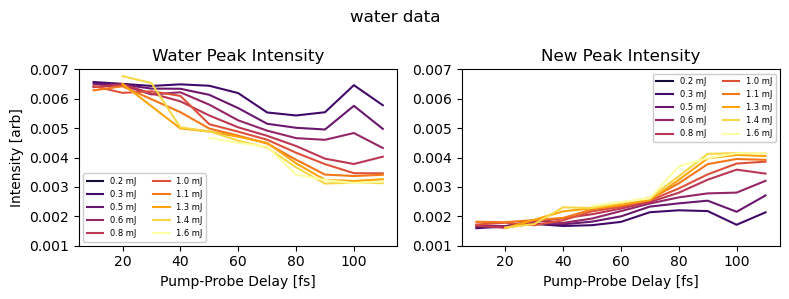

In [42]:
# or cut the other way, peak height vs time as fxn of power

plt.figure(figsize=(8,3))
plt.suptitle('%s data' % ds_name)

plt.subplot(121)
plt.title('Water Peak Intensity')
for pw_idx, bp in enumerate(pump_powers):
    
    y = normalize(rp_means)[:,pw_idx,wat_peak_pos]
    plt.plot(time_delays[y > 0], y[y > 0],
            color=cm.inferno(bp/pump_powers.max()) )
    
    
plt.xlabel('Pump-Probe Delay [fs]')
plt.ylabel('Intensity [arb]')
plt.legend(['%.1f mJ' % (float(p) * auc_to_mJ,) for p in pump_powers],
          prop={'size': 6}, ncol=2, framealpha=1.0)
plt.ylim([0.001,0.007])
    
plt.subplot(122)
plt.title('New Peak Intensity')
for pw_idx, bp in enumerate(pump_powers):
    
    y = normalize(rp_means)[:,pw_idx,new_peak_pos]
    plt.plot(time_delays[y > 0], y[y > 0],
            color=cm.inferno(bp/pump_powers.max()) )
    
plt.xlabel('Pump-Probe Delay [fs]')
#plt.ylabel('Intensity [arb]')
plt.legend(['%.1f mJ' % (float(p) * auc_to_mJ,) for p in pump_powers],
          prop={'size': 6}, ncol=2, framealpha=1.0)
plt.ylim([0.001,0.007])
#plt.ylim([0.003,0.005])
    
plt.tight_layout()
#plt.savefig('figures/peak_ints_vs_delay-power_%s.pdf' % ds_name)
plt.show()